In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 14s 2s/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 1s 126ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 1s 127ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 1s 156ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 1s 153ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 1s 136ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 1s 122ms/step - loss: 64.2200 - mae: 64.7354
Epoch 8/100
8/8 [==============================] - 1s 140ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 1s 133ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 1s 135ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [=======================

8/8 [==============================] - 1s 175ms/step - loss: 18.6104 - mae: 18.8090
Epoch 87/100
8/8 [==============================] - 1s 171ms/step - loss: 13.3051 - mae: 14.0633
Epoch 88/100
8/8 [==============================] - 2s 191ms/step - loss: 16.9851 - mae: 17.7980
Epoch 89/100
8/8 [==============================] - 1s 174ms/step - loss: 17.5987 - mae: 17.6918
Epoch 90/100
8/8 [==============================] - 1s 152ms/step - loss: 19.9006 - mae: 20.7798
Epoch 91/100
8/8 [==============================] - 1s 157ms/step - loss: 11.7727 - mae: 12.3275
Epoch 92/100
8/8 [==============================] - 1s 169ms/step - loss: 21.1379 - mae: 21.7259
Epoch 93/100
8/8 [==============================] - 1s 182ms/step - loss: 16.1472 - mae: 16.6410
Epoch 94/100
8/8 [==============================] - 1s 176ms/step - loss: 14.7253 - mae: 14.6831
Epoch 95/100
8/8 [==============================] - 1s 186ms/step - loss: 14.3187 - mae: 14.9223
Epoch 96/100
8/8 [=========================

(1e-08, 0.0001, 0.0, 30.0)

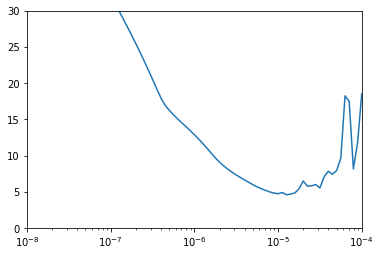

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 13s 410ms/step - loss: 21.5797 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 2s 66ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 2s 55ms/step - loss: 6.6399 - mae: 7.1323
Epoch 4/500
31/31 [==============================] - 2s 50ms/step - loss: 6.2134 - mae: 6.6875
Epoch 5/500
31/31 [==============================] - 2s 49ms/step - loss: 6.0325 - mae: 6.5202
Epoch 6/500
31/31 [==============================] - 1s 48ms/step - loss: 5.6138 - mae: 6.0969
Epoch 7/500
31/31 [==============================] - 1s 43ms/step - loss: 5.3885 - mae: 5.8660
Epoch 8/500
31/31 [==============================] - 1s 48ms/step - loss: 5.3508 - mae: 5.8277
Epoch 9/500
31/31 [==============================] - 1s 45ms/step - loss: 5.2078 - mae: 5.7007
Epoch 10/500
31/31 [==============================] - 1s 43ms/step - loss: 5.2516 - mae: 5.7409
Epoch 11/500
31/31 [=========================

31/31 [==============================] - 1s 46ms/step - loss: 4.3724 - mae: 4.8506
Epoch 87/500
31/31 [==============================] - 1s 46ms/step - loss: 4.2628 - mae: 4.7395
Epoch 88/500
31/31 [==============================] - 2s 49ms/step - loss: 4.3074 - mae: 4.7814
Epoch 89/500
31/31 [==============================] - 2s 51ms/step - loss: 4.2182 - mae: 4.7046
Epoch 90/500
31/31 [==============================] - 1s 48ms/step - loss: 4.2281 - mae: 4.6984
Epoch 91/500
31/31 [==============================] - 2s 51ms/step - loss: 4.2344 - mae: 4.7097
Epoch 92/500
31/31 [==============================] - 2s 59ms/step - loss: 4.2467 - mae: 4.7276
Epoch 93/500
31/31 [==============================] - 2s 68ms/step - loss: 4.2327 - mae: 4.7053
Epoch 94/500
31/31 [==============================] - 2s 60ms/step - loss: 4.2288 - mae: 4.6937
Epoch 95/500
31/31 [==============================] - 2s 68ms/step - loss: 4.3050 - mae: 4.7821
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 2s 71ms/step - loss: 4.1142 - mae: 4.5886
Epoch 171/500
31/31 [==============================] - 2s 70ms/step - loss: 4.2490 - mae: 4.7156
Epoch 172/500
31/31 [==============================] - 3s 81ms/step - loss: 4.1222 - mae: 4.6016
Epoch 173/500
31/31 [==============================] - 3s 84ms/step - loss: 4.1672 - mae: 4.6374
Epoch 174/500
31/31 [==============================] - 3s 87ms/step - loss: 4.1088 - mae: 4.5783
Epoch 175/500
31/31 [==============================] - 2s 74ms/step - loss: 4.1054 - mae: 4.5807
Epoch 176/500
31/31 [==============================] - 2s 68ms/step - loss: 4.1267 - mae: 4.5935
Epoch 177/500
31/31 [==============================] - 2s 72ms/step - loss: 4.1359 - mae: 4.6065
Epoch 178/500
31/31 [==============================] - 2s 70ms/step - loss: 4.1290 - mae: 4.5936
Epoch 179/500
31/31 [==============================] - 2s 71ms/step - loss: 4.1112 - mae: 4.5798
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 39ms/step - loss: 4.0444 - mae: 4.5176
Epoch 255/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0333 - mae: 4.5084
Epoch 256/500
31/31 [==============================] - 1s 40ms/step - loss: 4.1223 - mae: 4.6002
Epoch 257/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0907 - mae: 4.5722
Epoch 258/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0945 - mae: 4.5647
Epoch 259/500
31/31 [==============================] - 1s 40ms/step - loss: 4.0661 - mae: 4.5353
Epoch 260/500
31/31 [==============================] - 1s 40ms/step - loss: 4.0534 - mae: 4.5306
Epoch 261/500
31/31 [==============================] - 1s 40ms/step - loss: 4.1238 - mae: 4.5885
Epoch 262/500
31/31 [==============================] - 1s 39ms/step - loss: 4.1608 - mae: 4.6407
Epoch 263/500
31/31 [==============================] - 1s 40ms/step - loss: 4.1068 - mae: 4.5747
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 40ms/step - loss: 4.0230 - mae: 4.4920
Epoch 339/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9935 - mae: 4.4697
Epoch 340/500
31/31 [==============================] - 1s 40ms/step - loss: 3.9757 - mae: 4.4504
Epoch 341/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0629 - mae: 4.5254
Epoch 342/500
31/31 [==============================] - 1s 40ms/step - loss: 4.0888 - mae: 4.5734
Epoch 343/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0146 - mae: 4.4879
Epoch 344/500
31/31 [==============================] - 1s 37ms/step - loss: 4.0201 - mae: 4.4906
Epoch 345/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0391 - mae: 4.5172
Epoch 346/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0243 - mae: 4.4972
Epoch 347/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9780 - mae: 4.4491
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 40ms/step - loss: 3.9358 - mae: 4.4032
Epoch 423/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9519 - mae: 4.4215
Epoch 424/500
31/31 [==============================] - 1s 40ms/step - loss: 3.9610 - mae: 4.4271
Epoch 425/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9569 - mae: 4.4240
Epoch 426/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9658 - mae: 4.4411
Epoch 427/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9523 - mae: 4.4292
Epoch 428/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9772 - mae: 4.4544
Epoch 429/500
31/31 [==============================] - 1s 39ms/step - loss: 3.9215 - mae: 4.3967
Epoch 430/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9367 - mae: 4.4065
Epoch 431/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9941 - mae: 4.4696
Epoch 432/500
31/31 [=======================

In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

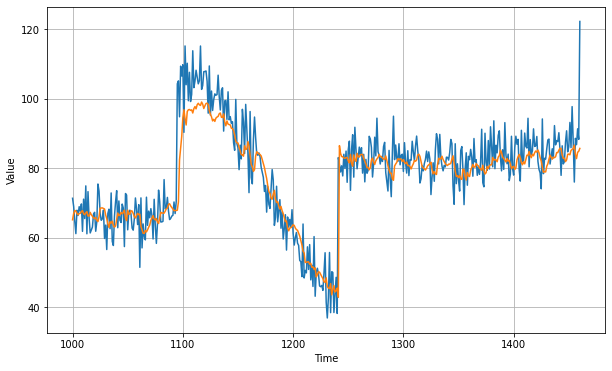

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


5.082686

<Figure size 432x288 with 0 Axes>

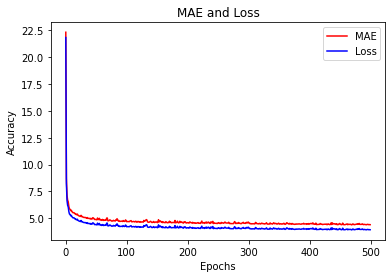

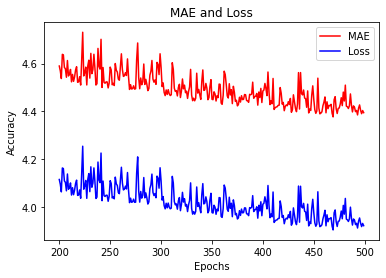

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()